## Contrastive Learning: An MNIST Case Study

**Objective:** To compare the effectiveness of InfoNCE against standard MSE (Mean Squared Error) for learning meaningful image representations. 

**The Hypothesis:** InfoNCE, by explicitly pushing incorrect classes away (negative sampling), will learn a more robust and well-clustered latent space than MSE, which only minimizes distance to the correct target.

**Architecture:** 
- **Encoder:** 2-layer CNN
- **Latent Dim:** 64
- **Dataset:** MNIST

### Setup

In [1]:
import sys
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE

# --- path setup ---
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if base_path not in sys.path:
    sys.path.append(base_path)

# --- imports ---
from src.config import CONFIG
from src.utils import get_data, evaluate_accuracy, test_noise, plot_negative_sample

from src.utils import get_embeddings
from src.models import ContrastiveModel
from src.train import train_epoch, reset

print(f"Project loaded. Running on {CONFIG['device']}")
print(f"Configuration: {CONFIG}")

Project loaded. Running on cuda
Configuration: {'batch_size': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'dropout': 0.2, 'epochs': 15, 'embedding_dim': 64, 'temperature': 0.07, 'device': 'cuda', 'seed': 42}


### Dataset

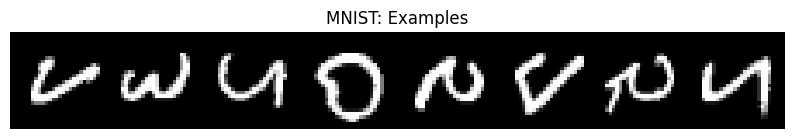

In [2]:
train_loader, test_loader = get_data(CONFIG["batch_size"])

examples = next(iter(train_loader))[0][:8]
grid_img = examples.view(-1, 28)
plt.figure(figsize=(10, 2))
plt.imshow(grid_img.numpy().transpose(), cmap='gray')
plt.title("MNIST: Examples")
plt.axis('off')
plt.show()

### Experiment Phase

We will train two identical models with different objective functions:
1. **InfoNCE:** Trained with Contrastive Loss.
2. **MSE:** Trained with Mean Squared Error.

In [3]:
# --- train model with InfoNCE ---
print(f"\n>>> Training InfoNCE Model ...")
model_nce, opt_nce = reset()
nce_stats = {"loss": [], "acc": []}

for epoch in range(1, CONFIG["epochs"] + 1):
    loss = train_epoch(model_nce, opt_nce, train_loader, loss_type="infonce")
    acc = evaluate_accuracy(model_nce, test_loader)
    
    nce_stats["loss"].append(loss)
    nce_stats["acc"].append(acc)
    print(f"Epoch {epoch} / {CONFIG['epochs']}: Loss {loss:.4f} | Acc {acc:.2f}%")

# --- train model with MSE ---
print(f"\n>>> Training MSE Model ...")
model_mse, opt_mse = reset()
mse_stats = {"loss": [], "acc": []}

for epoch in range(1, CONFIG["epochs"] + 1):
    loss = train_epoch(model_mse, opt_mse, train_loader, loss_type="mse")
    acc = evaluate_accuracy(model_mse, test_loader)
    
    mse_stats["loss"].append(loss)
    mse_stats["acc"].append(acc)
    print(f"Epoch {epoch} / {CONFIG['epochs']}: Loss {loss:.4f} | Acc {acc:.2f}%")


>>> Training InfoNCE Model ...


Epoch 1 / 15: Loss 3.5678 | Acc 98.17%
Epoch 2 / 15: Loss 3.3242 | Acc 98.62%
Epoch 3 / 15: Loss 3.3125 | Acc 98.64%
Epoch 4 / 15: Loss 3.3026 | Acc 98.89%
Epoch 5 / 15: Loss 3.2981 | Acc 98.87%
Epoch 6 / 15: Loss 3.2925 | Acc 98.94%
Epoch 7 / 15: Loss 3.2894 | Acc 99.18%
Epoch 8 / 15: Loss 3.2877 | Acc 99.09%
Epoch 9 / 15: Loss 3.2860 | Acc 98.85%
Epoch 10 / 15: Loss 3.2831 | Acc 99.02%
Epoch 11 / 15: Loss 3.2838 | Acc 99.06%
Epoch 12 / 15: Loss 3.2831 | Acc 99.06%
Epoch 13 / 15: Loss 3.2792 | Acc 99.19%
Epoch 14 / 15: Loss 3.2794 | Acc 99.10%
Epoch 15 / 15: Loss 3.2796 | Acc 99.03%

>>> Training MSE Model ...
Epoch 1 / 15: Loss 0.0045 | Acc 97.70%
Epoch 2 / 15: Loss 0.0018 | Acc 97.91%
Epoch 3 / 15: Loss 0.0016 | Acc 98.02%
Epoch 4 / 15: Loss 0.0015 | Acc 98.27%
Epoch 5 / 15: Loss 0.0014 | Acc 98.34%
Epoch 6 / 15: Loss 0.0013 | Acc 98.15%
Epoch 7 / 15: Loss 0.0012 | Acc 98.34%
Epoch 8 / 15: Loss 0.0011 | Acc 98.51%
Epoch 9 / 15: Loss 0.0009 | Acc 98.48%
Epoch 10 / 15: Loss 0.0007 | A

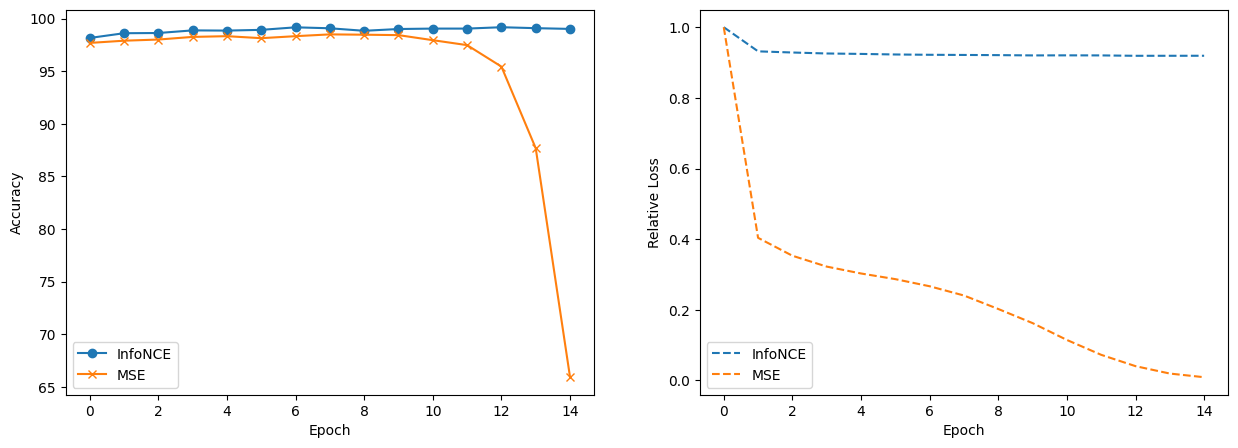

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(nce_stats["acc"], label="InfoNCE", marker='o')
ax1.plot(mse_stats["acc"], label="MSE", marker='x')
#ax1.set_title("Test Accuracy: InfoNCE vs MSE")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(False)

# Loss
norm_nce_loss = [l / nce_stats["loss"][0] for l in nce_stats["loss"]]
norm_mse_loss = [l / mse_stats["loss"][0] for l in mse_stats["loss"]]

ax2.plot(norm_nce_loss, label="InfoNCE", linestyle='--')
ax2.plot(norm_mse_loss, label="MSE", linestyle='--')
#ax2.set_title("Relative Loss Decrease (Normalized)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Relative Loss")
ax2.legend()
ax2.grid(False)

plt.show()

### Evaluation

Computing t-SNE ...


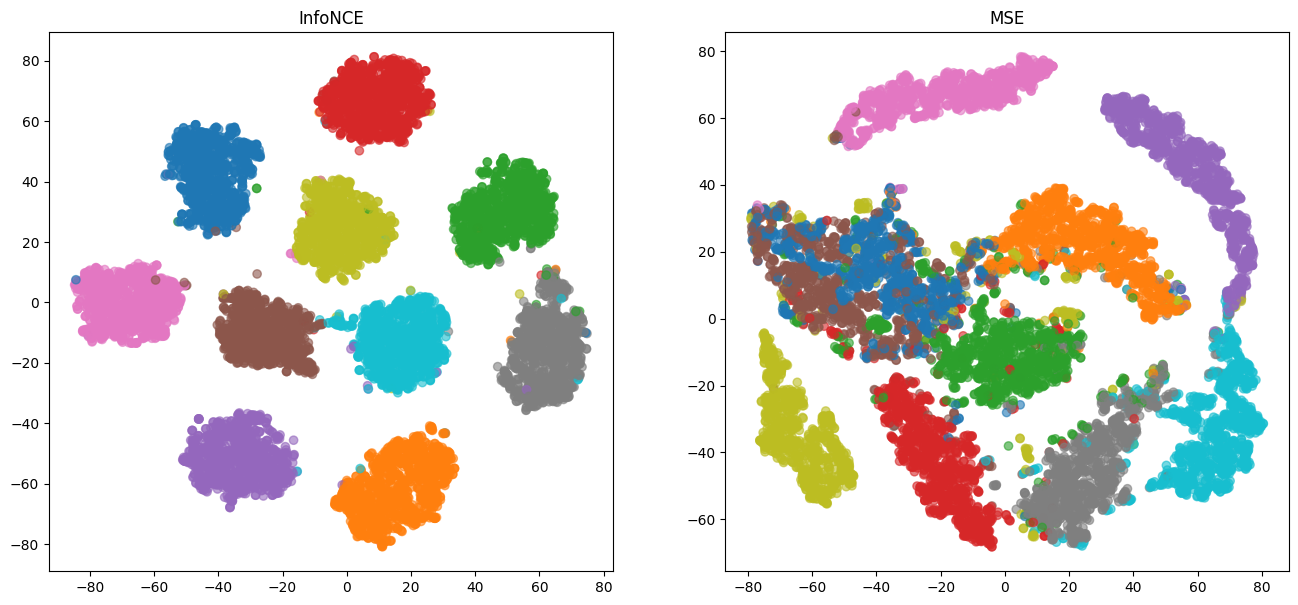

In [5]:
# plot t-SNE
print("Computing t-SNE ...")
nce_emb, nce_lbl = get_embeddings(model_nce, test_loader)
mse_emb, mse_lbl = get_embeddings(model_mse, test_loader)

tsne = TSNE(n_components=2, random_state=42)
nce_2d = tsne.fit_transform(nce_emb)
mse_2d = tsne.fit_transform(mse_emb)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ax1.scatter(nce_2d[:, 0], nce_2d[:, 1], c=nce_lbl, cmap='tab10', alpha=0.6)
ax1.set_title("InfoNCE")
ax2.scatter(mse_2d[:, 0], mse_2d[:, 1], c=mse_lbl, cmap='tab10', alpha=0.6)
ax2.set_title("MSE")
plt.show()

We inject Gaussian noise into the test images to see which model's representation is more robust. A contrastive model usually learns structural features that persist through noise better than pixel-matching models.

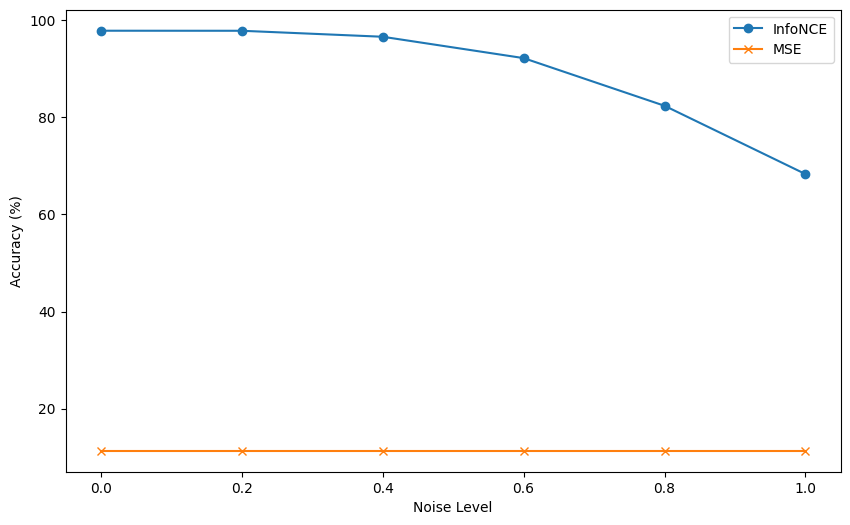

In [6]:
noise_range = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
nce_rob = test_noise(model_nce, test_loader, noise_range)
mse_rob = test_noise(model_mse, test_loader, noise_range)

plt.figure(figsize=(10, 6))
plt.plot(noise_range, nce_rob, marker='o', label='InfoNCE')
plt.plot(noise_range, mse_rob, marker='x', label='MSE')
plt.xlabel("Noise Level")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(False)
plt.show()

InfoNCE Worst Failure Case:


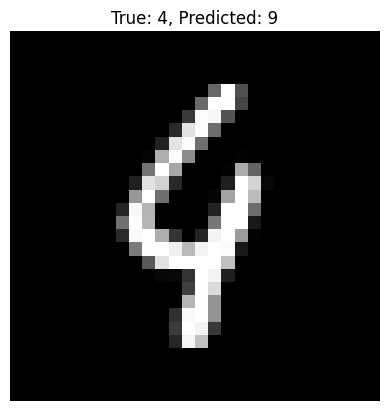

In [8]:
print("InfoNCE Worst Failure Case:")
plot_negative_sample(model_nce, test_loader)